# SCC scRNA-Seq (Yuan 2022) — Ras–CSC state summary

This notebook processes the SCC scRNA-Seq dataset from Yuan et al. (Nature 2022) to derive
model-facing summary quantities for the Ras–CSC–microenvironment ODE:

- CSC fraction among tumour basal cells (C_SCC)
- TGFβ signalling scores in CSC vs other tumour cells
- LEPR expression and LEPR+ fractions in CSC vs other tumour cells
- PI3K/AKT/mTOR pathway scores in CSC vs other tumour cells
- Context scores (angiogenesis, leptin) as supporting microenvironment information

Inputs:
- data/raw/GSE207975/GSE207975_Yuan2021_SCC_scRNAseq_TPM.csv.gz
- data/raw/GSE207975/GSE207975_Yuan2021_SCC_scRNAseq_counts.csv.gz
- external/yuan2022/Technical_noise_test_Leo_SCC_all_tumor_mCherry_K14morethan7_V1.R
- external/yuan2022/Yuanetal2022_Nature_scRNAseq_jupyternotebook.ipynb

Outputs:
- data/interim/omics_qc/scc_scRNA_K14pos_expression_logged_filtered.csv
- data/interim/omics_qc/scc_scRNA_K14pos_counts_filtered.csv
- data/interim/omics_qc/scc_scRNA_K14pos_metadata_filtered.csv
- data/processed/omics_summaries/scRNA_SCC_RasCSC_state_summary.json


In [8]:
# Import path utilities and typing
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Import numerical and data libraries
import numpy as np
import pandas as pd

# Import plotting libraries for QC and visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Import sklearn tools for scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import nearest-neighbour graph utilities and igraph for clustering
from sklearn.neighbors import NearestNeighbors
import igraph as ig

# Import json and os for saving summaries
import json
import os

# Set seaborn style for plots
sns.set(style="ticks", font_scale=1.2)

# %%
# -----------------------------------------------------------------------
# Resolve project root and define key directories
# -----------------------------------------------------------------------

try:
    # Try to use __file__ if this is run as a script
    project_root: Path = Path(__file__).resolve().parents[1]
except NameError:
    # In a notebook, __file__ is not defined; assume this notebook is in project_root / "notebooks"
    project_root = Path("..").resolve()

# Define key directories relative to project root
data_raw_dir: Path = project_root / "data" / "raw" / "GSE207975"
data_interim_dir: Path = project_root / "data" / "interim" / "omics_qc"
data_processed_dir: Path = project_root / \
    "data" / "processed" / "omics_summaries"

# Create interim and processed directories if they do not exist
data_interim_dir.mkdir(parents=True, exist_ok=True)
data_processed_dir.mkdir(parents=True, exist_ok=True)

print("Project root:", project_root)
print("Raw data dir:", data_raw_dir)
print("Interim dir:", data_interim_dir)
print("Processed dir:", data_processed_dir)

Project root: /home/secondbook5/JHU_Bioinformatics/SystemsBiology/ras_csc_feedback_switch
Raw data dir: /home/secondbook5/JHU_Bioinformatics/SystemsBiology/ras_csc_feedback_switch/data/raw/GSE207975
Interim dir: /home/secondbook5/JHU_Bioinformatics/SystemsBiology/ras_csc_feedback_switch/data/interim/omics_qc
Processed dir: /home/secondbook5/JHU_Bioinformatics/SystemsBiology/ras_csc_feedback_switch/data/processed/omics_summaries


In [9]:
def load_scRNA_matrices(
    tpm_path: Path,
    counts_path: Path
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load SCC scRNA-Seq TPM and counts matrices from GSE207975.

    This function reads the TPM and counts matrices for the SCC scRNA dataset
    and returns them as pandas DataFrames with genes as rows and cells as columns.
    It explicitly checks that gene indices and cell columns match between TPM
    and counts, because any mismatch would break downstream analysis and lead
    to incorrect biological inferences.

    Args:
        tpm_path:
            Path to the TPM matrix file (CSV or gzipped CSV).
        counts_path:
            Path to the counts matrix file (CSV or gzipped CSV).

    Returns:
        A tuple (tpm, counts) where:
            tpm:
                DataFrame of TPM values (genes x cells).
            counts:
                DataFrame of raw counts (genes x cells).

    Raises:
        FileNotFoundError:
            If either of the input files does not exist.
        ValueError:
            If the shapes or indices of TPM and counts matrices are inconsistent.
    """
    # Check that the TPM file exists
    if not tpm_path.exists():
        raise FileNotFoundError(
            f"load_scRNA_matrices: TPM file not found at '{tpm_path}'."
        )

    # Check that the counts file exists
    if not counts_path.exists():
        raise FileNotFoundError(
            f"load_scRNA_matrices: counts file not found at '{counts_path}'."
        )

    # Load TPM matrix (genes x cells)
    tpm: pd.DataFrame = pd.read_csv(tpm_path, index_col=0)

    # Load counts matrix (genes x cells)
    counts: pd.DataFrame = pd.read_csv(counts_path, index_col=0)

    # Check that gene sets are identical and in the same order
    if not tpm.index.equals(counts.index):
        raise ValueError(
            "load_scRNA_matrices: TPM and counts gene indices do not match. "
            "Inspect the raw files for reordering or missing genes."
        )

    # Check that cell sets are identical and in the same order
    if not tpm.columns.equals(counts.columns):
        raise ValueError(
            "load_scRNA_matrices: TPM and counts cell columns do not match. "
            "Inspect the raw files for reordering or missing cells."
        )

    # Return TPM and counts matrices
    return tpm, counts


def log2_transform_tpm(
    tpm: pd.DataFrame,
    pseudocount: float = 1.0
) -> pd.DataFrame:
    """
    Compute log2(TPM + pseudocount) for the TPM matrix.

    This transformation stabilises variance and is standard for
    scRNA-Seq exploratory analysis. A positive pseudocount ensures that
    zero-TPM entries map to finite log-values.

    Args:
        tpm:
            DataFrame of TPM values (genes x cells).
        pseudocount:
            Value added to TPM before log2 transformation. Must be > 0.

    Returns:
        log_tpm:
            DataFrame of log2-transformed TPM values.

    Raises:
        ValueError:
            If any TPM value is negative or pseudocount is not positive.
    """
    # Ensure pseudocount is positive
    if pseudocount <= 0.0:
        raise ValueError(
            f"log2_transform_tpm: pseudocount must be positive, got {pseudocount}."
        )

    # Check for negative TPM values
    if (tpm.values < 0).any():
        raise ValueError(
            "log2_transform_tpm: TPM matrix contains negative values. "
            "Values should be non-negative."
        )

    # Compute log2(TPM + pseudocount)
    log_tpm: pd.DataFrame = np.log2(tpm + pseudocount)

    return log_tpm


def compute_qc_metrics(
    log_tpm: pd.DataFrame,
    detection_threshold: float = 1.0
) -> Tuple[pd.Series, pd.Series]:
    """
    Compute basic QC metrics: detected genes per cell and detected cells per gene.

    detection_threshold corresponds to log2(TPM + 1); values above this threshold
    are considered expressed. The thresholds for downstream filtering will be
    applied on these detection counts.

    Args:
        log_tpm:
            DataFrame of log2(TPM + pseudocount) values (genes x cells).
        detection_threshold:
            Threshold above which a gene is considered detected in a cell.

    Returns:
        num_genes_per_cell:
            Series of number of detected genes for each cell.
        num_cells_per_gene:
            Series of number of cells in which each gene is detected.
    """
    # Build a boolean detection matrix (genes x cells)
    detected = log_tpm > detection_threshold

    # Count detected genes per cell (sum over genes -> cells)
    num_genes_per_cell: pd.Series = detected.sum(axis=0)

    # Count detected cells per gene (sum over cells -> genes)
    num_cells_per_gene: pd.Series = detected.sum(axis=1)

    return num_genes_per_cell, num_cells_per_gene


def select_hvgs_from_r_output(
    variable_genes_path: Path,
    log_tpm_k14: pd.DataFrame
) -> pd.DataFrame:
    """
    Subset K14+ log_TPM matrix to highly variable genes defined by Yuan's R pipeline.

    The R script Technical_noise_test_Leo_SCC_all_tumor_mCherry_K14morethan7_V1.R
    produces a CSV with a logical column (e.g. 'sig') indicating HVGs. This
    function loads that file and filters the gene expression accordingly.

    Args:
        variable_genes_path:
            Path to the CSV file with HVG flags from the R script.
        log_tpm_k14:
            DataFrame of log2(TPM+1) for K14+ cells (genes x cells).

    Returns:
        log_tpm_hvg:
            DataFrame of log2(TPM+1) restricted to highly variable genes.

    Raises:
        FileNotFoundError:
            If the variable genes CSV does not exist.
        KeyError:
            If expected column 'sig' is missing.
    """
    # Check that the HVG CSV exists
    if not variable_genes_path.exists():
        raise FileNotFoundError(
            f"select_hvgs_from_r_output: HVG file not found at '{variable_genes_path}'. "
            "Run the R technical noise script or provide this file."
        )

    # Load HVG table (assume it has a boolean column named 'sig')
    hvg_df = pd.read_csv(variable_genes_path, index_col=0)

    # Check for 'sig' column
    if "sig" not in hvg_df.columns:
        raise KeyError(
            "select_hvgs_from_r_output: Expected column 'sig' in HVG CSV. "
            "Update this function if your column name differs."
        )

    # Create boolean mask of HVGs
    hvg_mask = hvg_df["sig"].astype(bool)

    # Select HVG gene IDs
    hvg_genes = hvg_df.index[hvg_mask]

    # Intersect HVG gene IDs with genes present in log_tpm_k14
    hvg_genes_in_data = [g for g in hvg_genes if g in log_tpm_k14.index]

    # Subset expression matrix to HVGs
    log_tpm_hvg = log_tpm_k14.loc[hvg_genes_in_data, :]

    print(
        f"Selected {log_tpm_hvg.shape[0]} HVGs present in K14+ data (R-based).")

    return log_tpm_hvg


def select_hvgs_by_variance(
    log_tpm_k14: pd.DataFrame,
    top_n: int = 2000
) -> pd.DataFrame:
    """
    Fallback HVG selection based on per-gene variance across K14+ cells.

    This is a simpler alternative if the technical-noise-based HVG list
    is not available. It does not model ERCC spike-ins and should be
    treated as an approximation, but is adequate for clustering.

    Args:
        log_tpm_k14:
            DataFrame of log2(TPM+1) for K14+ cells (genes x cells).
        top_n:
            Number of top variable genes to retain.

    Returns:
        log_tpm_hvg:
            DataFrame restricted to the top_n most variable genes.
    """
    # Compute per-gene variance across cells
    gene_var = log_tpm_k14.var(axis=1)

    # Sort genes by variance descending and select top_n
    top_genes = gene_var.sort_values(ascending=False).head(top_n).index

    # Subset expression matrix to top variable genes
    log_tpm_hvg = log_tpm_k14.loc[top_genes, :]

    print(f"Selected {log_tpm_hvg.shape[0]} HVGs by variance.")

    return log_tpm_hvg


def run_pca_on_hvgs(
    log_tpm_hvg: pd.DataFrame,
    n_components: int = 50
) -> Tuple[pd.DataFrame, PCA]:
    """
    Run PCA on scaled HVG expression for K14+ cells.

    The HVG expression matrix is transposed to cells x genes, z-scored per gene,
    and then subjected to PCA. The resulting scores are returned as a DataFrame
    with cells as rows and PCs as columns.

    Args:
        log_tpm_hvg:
            HVG expression matrix (genes x cells).
        n_components:
            Number of principal components to compute.

    Returns:
        pca_scores:
            DataFrame of PCA scores (cells x PCs).
        pca_model:
            Fitted sklearn PCA object.
    """
    # Transpose expression to cells x genes
    expr_cells = log_tpm_hvg.T

    # Initialise scaler
    scaler = StandardScaler()

    # Fit scaler and transform expression
    expr_scaled = scaler.fit_transform(expr_cells)

    # Initialise PCA
    pca_model = PCA(n_components=n_components)

    # Fit PCA and compute scores
    scores = pca_model.fit_transform(expr_scaled)

    # Build DataFrame of PCA scores
    pc_cols = [f"PC{i+1}" for i in range(scores.shape[1])]
    pca_scores = pd.DataFrame(scores, index=expr_cells.index, columns=pc_cols)

    return pca_scores, pca_model


def build_knn_graph(
    pca_scores: pd.DataFrame,
    n_pcs: int = 30,
    n_neighbors: int = 20
) -> ig.Graph:
    """
    Build a k-nearest neighbour (KNN) graph from PCA scores.

    This function uses Euclidean distance in PCA space to find k-nearest
    neighbours for each cell and builds an undirected igraph Graph where
    edges connect nearest neighbours.

    Args:
        pca_scores:
            DataFrame of PCA scores with cells as rows and PCs as columns.
        n_pcs:
            Number of leading PCs to use for distance calculation.
        n_neighbors:
            Number of neighbours (k) to use for the KNN graph.

    Returns:
        g:
            igraph Graph with one vertex per cell and edges for neighbour relations.

    Raises:
        ValueError:
            If n_pcs is larger than the number of available PCs.
    """
    # Check that requested PCs are available
    if n_pcs > pca_scores.shape[1]:
        raise ValueError(
            f"build_knn_graph: requested {n_pcs} PCs, but only {pca_scores.shape[1]} are available."
        )

    # Slice PCA scores to first n_pcs
    pca_used = pca_scores.iloc[:, :n_pcs]

    # Initialise NearestNeighbors model (+1 for self)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, metric="euclidean")

    # Fit neighbours model
    nbrs.fit(pca_used.values)

    # Compute neighbours (distances unused here)
    distances, indices = nbrs.kneighbors(pca_used.values)

    # Build edge list as a set of undirected edges
    edges = set()
    for i, neighbors in enumerate(indices):
        for j in neighbors[1:]:  # skip self
            edge = tuple(sorted((i, j)))
            edges.add(edge)

    # Create igraph Graph
    g = ig.Graph()
    g.add_vertices(pca_used.shape[0])
    g.add_edges(list(edges))

    # Store cell barcodes as vertex attribute
    g.vs["cell_barcode"] = list(pca_used.index)

    return g


def run_louvain_clustering_igraph(
    g: ig.Graph
) -> pd.Series:
    """
    Run Louvain (multilevel) community detection on an igraph Graph.

    This uses igraph's community_multilevel implementation of the Louvain
    method to partition the graph into communities. Cluster labels are
    returned as integer IDs.

    Args:
        g:
            igraph Graph with vertices representing cells.

    Returns:
        clusters:
            Series mapping cell barcodes to integer Louvain cluster labels.
    """
    # Run Louvain community detection
    partition = g.community_multilevel()

    # Extract integer cluster labels
    cluster_labels = np.array(partition.membership, dtype=int)

    # Retrieve cell barcodes
    cell_barcodes = g.vs["cell_barcode"]

    # Build mapping barcode -> cluster id
    clusters = pd.Series(
        cluster_labels, index=cell_barcodes, name="louvain_cluster")

    return clusters


def find_genes_by_substring(
    expr: pd.DataFrame,
    substrings: List[str],
    max_hits: int = 20
) -> pd.Index:
    """
    Search expression matrix row index for genes whose IDs contain any
    of the provided substrings (case-insensitive).

    This is a defensive helper for cases where we only know a partial
    Ensembl ID (without version) or a gene symbol appears in the ID.

    Args:
        expr:
            DataFrame of gene expression with genes as index.
        substrings:
            List of substrings to search for in gene IDs.
        max_hits:
            Maximum number of matching genes to return.

    Returns:
        matches:
            Index of gene IDs that matched at least one substring.

    Raises:
        ValueError:
            If the expression matrix has an empty index.
    """
    # Ensure expression index is not empty
    if expr.index.empty:
        raise ValueError(
            "find_genes_by_substring: expression matrix has empty index."
        )

    # Normalise substrings to lowercase
    substrings_lower = [s.lower() for s in substrings]

    # Initialise boolean mask over genes
    mask = pd.Series(False, index=expr.index)

    # Update mask for each substring
    for s in substrings_lower:
        mask = mask | expr.index.str.lower().str.contains(s)

    # Extract matching gene IDs
    matches = expr.index[mask]

    # Truncate if too many matches
    if len(matches) > max_hits:
        print(
            f"find_genes_by_substring: found {len(matches)} matches; "
            f"returning first {max_hits}."
        )
        matches = matches[:max_hits]

    return matches


def summarize_markers_by_cluster(
    metadata_k14: pd.DataFrame,
    cluster_col: str = "louvain_cluster",
    marker_cols: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Summarise marker expression by Louvain cluster.

    Args:
        metadata_k14:
            DataFrame with per-cell metadata including cluster labels
            and marker expression columns.
        cluster_col:
            Name of the column with integer cluster labels.
        marker_cols:
            List of marker columns to summarise. If None, uses all
            columns ending with '_expr'.

    Returns:
        summary_df:
            DataFrame with one row per cluster and mean marker
            expression in each cluster.

    Raises:
        KeyError:
            If cluster_col is missing from metadata_k14.
    """
    # Check that cluster column exists
    if cluster_col not in metadata_k14.columns:
        raise KeyError(
            f"summarize_markers_by_cluster: '{cluster_col}' not found in metadata_k14."
        )

    # Infer marker columns if not provided
    if marker_cols is None:
        marker_cols = [c for c in metadata_k14.columns if c.endswith("_expr")]

    # Build subset with cluster + marker columns
    cols = [cluster_col] + marker_cols
    sub = metadata_k14[cols].copy()

    # Group by cluster and compute mean expression
    summary_df = sub.groupby(cluster_col).mean(numeric_only=True)

    return summary_df


def summarize_csc_vs_non(
    metadata_k14: pd.DataFrame,
    expr_mat: pd.DataFrame,
    lepr_id: str,
    krt14_id: str
) -> pd.DataFrame:
    """
    Summarise basic markers for CSC vs non-CSC populations.

    This function uses the 'is_CSC' flag in metadata_k14 and the expression
    matrix to compute group-level statistics for LEPR and Krt14.

    Args:
        metadata_k14:
            DataFrame with per-cell metadata including 'is_CSC'.
        expr_mat:
            Expression matrix (genes x cells) with log2(TPM+1) values.
        lepr_id:
            Gene ID for Lepr.
        krt14_id:
            Gene ID for Krt14.

    Returns:
        summary_df:
            DataFrame with one row per group (CSC / non_CSC) and summary
            statistics for LEPR and Krt14.

    Raises:
        KeyError:
            If 'is_CSC' is missing from metadata_k14.
    """
    # Check that CSC flag exists
    if "is_CSC" not in metadata_k14.columns:
        raise KeyError(
            "summarize_csc_vs_non: 'is_CSC' column not found in metadata_k14."
        )

    # Align expression to metadata index
    expr_aligned = expr_mat.loc[[lepr_id, krt14_id], metadata_k14.index]

    summaries = []
    for label, group in metadata_k14.groupby("is_CSC"):
        status = "CSC" if label else "non_CSC"
        lepr_vals = expr_aligned.loc[lepr_id, group.index]
        k14_vals = expr_aligned.loc[krt14_id, group.index]

        summaries.append({
            "group": status,
            "n_cells": group.shape[0],
            "Lepr_mean": float(lepr_vals.mean()),
            "Lepr_median": float(lepr_vals.median()),
            "Krt14_mean": float(k14_vals.mean()),
            "Krt14_median": float(k14_vals.median()),
        })

    summary_df = pd.DataFrame(summaries).set_index("group")

    return summary_df



## 1. Load TPM and counts, compute log2 TPM

In [10]:
# Define paths for TPM and counts matrices
tpm_path = data_raw_dir / "GSE207975_Yuan2021_SCC_scRNAseq_TPM.csv.gz"
counts_path = data_raw_dir / "GSE207975_Yuan2021_SCC_scRNAseq_counts.csv.gz"

# Load matrices
tpm, counts = load_scRNA_matrices(tpm_path, counts_path)

# Compute log2(TPM + 1)
log_tpm = log2_transform_tpm(tpm, pseudocount=1.0)

# Report shapes
print("TPM shape:", tpm.shape)
print("Counts shape:", counts.shape)
print("log2 TPM shape:", log_tpm.shape)

TPM shape: (55430, 2304)
Counts shape: (55430, 2304)
log2 TPM shape: (55430, 2304)


## 2. Basic QC filtering (genes per cell, cells per gene)


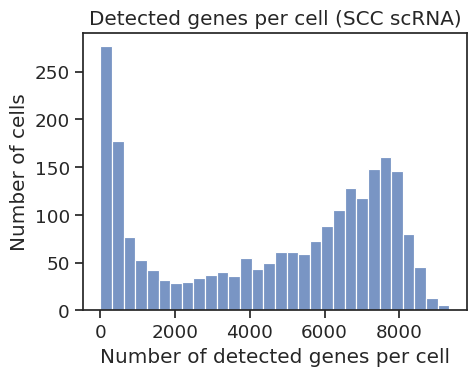

After QC - log_tpm_qc: (12562, 1587)
After QC - counts_qc: (12562, 1587)


In [11]:
# Compute QC metrics
num_genes_per_cell, num_cells_per_gene = compute_qc_metrics(
    log_tpm, detection_threshold=1.0
)

# Quick QC plot for genes per cell
plt.figure(figsize=(5, 4))
sns.histplot(num_genes_per_cell, bins=30, kde=False)
plt.xlabel("Number of detected genes per cell")
plt.ylabel("Number of cells")
plt.title("Detected genes per cell (SCC scRNA)")
plt.tight_layout()
plt.show()

# Define QC thresholds (these match the earlier pipeline)
min_genes_per_cell: int = 2500
min_cells_per_gene: int = 100

# Build masks
good_cells_mask = num_genes_per_cell >= min_genes_per_cell
good_genes_mask = num_cells_per_gene >= min_cells_per_gene

# Subset matrices
log_tpm_qc = log_tpm.loc[good_genes_mask, good_cells_mask]
counts_qc = counts.loc[good_genes_mask, good_cells_mask]

print("After QC - log_tpm_qc:", log_tpm_qc.shape)
print("After QC - counts_qc:", counts_qc.shape)

## 3. Select Krt14+ tumour basal cells using Yuan's K14 threshold

In [12]:
# Fixed Krt14 Ensembl ID with version (used in Yuan's pipeline)
krt14_id: str = "ENSMUSG00000045545.8"

# Ensure Krt14 is present
if krt14_id not in log_tpm_qc.index:
    raise KeyError(
        f"Krt14 gene ID '{krt14_id}' not found in filtered log_tpm_qc index. "
        "Check gene IDs or update krt14_id."
    )

# Extract Krt14 expression
krt14_expr = log_tpm_qc.loc[krt14_id, :]

# Define Krt14+ cells as log2(TPM+1) > 7 (as in Yuan)
krt14_pos_mask = krt14_expr > 7.0

# Subset to K14+ cells
log_tpm_k14 = log_tpm_qc.loc[:, krt14_pos_mask]
counts_k14 = counts_qc.loc[:, krt14_pos_mask]

print("Krt14+ log_tpm:", log_tpm_k14.shape)
print("Krt14+ counts:", counts_k14.shape)

# Save K14+ matrices for reuse
log_tpm_k14_path = data_interim_dir / \
    "scc_scRNA_K14pos_expression_logged_filtered.csv"
counts_k14_path = data_interim_dir / "scc_scRNA_K14pos_counts_filtered.csv"

log_tpm_k14.to_csv(log_tpm_k14_path)
counts_k14.to_csv(counts_k14_path)

print(f"Saved K14+ log_tpm to {log_tpm_k14_path}")
print(f"Saved K14+ counts to {counts_k14_path}")

Krt14+ log_tpm: (12562, 1504)
Krt14+ counts: (12562, 1504)
Saved K14+ log_tpm to /home/secondbook5/JHU_Bioinformatics/SystemsBiology/ras_csc_feedback_switch/data/interim/omics_qc/scc_scRNA_K14pos_expression_logged_filtered.csv
Saved K14+ counts to /home/secondbook5/JHU_Bioinformatics/SystemsBiology/ras_csc_feedback_switch/data/interim/omics_qc/scc_scRNA_K14pos_counts_filtered.csv


## 4. HVG selection (try R-based list, else variance)

In [13]:
hvg_r_output_path = data_interim_dir / \
    "all_tumor_K14morethan7_Counts_geneCollapsed_filtered_variable.csv"

try:
    log_tpm_hvg = select_hvgs_from_r_output(hvg_r_output_path, log_tpm_k14)
except FileNotFoundError as e:
    print(str(e))
    print("Falling back to variance-based HVG selection.")
    log_tpm_hvg = select_hvgs_by_variance(log_tpm_k14, top_n=2000)

print("HVG expression shape:", log_tpm_hvg.shape)

select_hvgs_from_r_output: HVG file not found at '/home/secondbook5/JHU_Bioinformatics/SystemsBiology/ras_csc_feedback_switch/data/interim/omics_qc/all_tumor_K14morethan7_Counts_geneCollapsed_filtered_variable.csv'. Run the R technical noise script or provide this file.
Falling back to variance-based HVG selection.


Selected 2000 HVGs by variance.
HVG expression shape: (2000, 1504)


## 5. Run PCA on HVGs and inspect variance explained

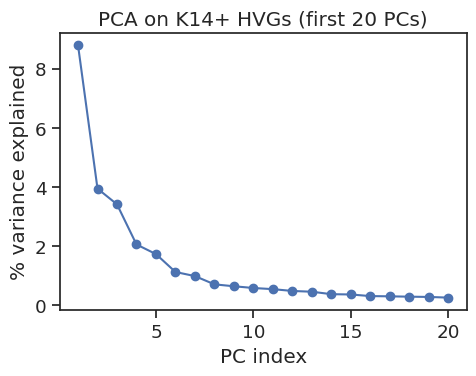

In [14]:
pca_scores, pca_model = run_pca_on_hvgs(log_tpm_hvg, n_components=50)

explained_var = pca_model.explained_variance_ratio_ * 100.0
plt.figure(figsize=(5, 4))
plt.plot(range(1, 21), explained_var[:20], marker="o")
plt.xlabel("PC index")
plt.ylabel("% variance explained")
plt.title("PCA on K14+ HVGs (first 20 PCs)")
plt.tight_layout()
plt.show()

## 6. Build KNN graph and run Louvain clustering


In [15]:
# Build KNN graph using 30 PCs and 20 neighbours
g_knn = build_knn_graph(pca_scores=pca_scores, n_pcs=30, n_neighbors=20)
print(g_knn)

# Run Louvain clustering
louvain_clusters = run_louvain_clustering_igraph(g_knn)

# Sanity check: cluster sizes
print("Louvain cluster sizes (raw):")
print(louvain_clusters.value_counts().sort_index())



IGRAPH U--- 1504 21645 --
+ attr: cell_barcode (v)
+ edges:
   0 --   46   69   70   91   99  123  126  139  148  152  174  303  312  356
364  439  448  538  733  774 1029 1347
   1 --    2   20   21   28   37   39   45   47   53   57   61   65   68   71
72   78   80   88   96   99  106  109  110  115  116  121  123  129  135  148
151  157  158  324  367  411 1011 1077 1123 1126 1206
   2 --    1   14   20   35   37   47   53   57   71   84   88   96   97   99
112  115  116  129  133  135  144  151  152  155  367 1126
   3 --    7   13   16   17   18   32   36   38   42   44   48   54   63   66
73  111  118  122  138  200  238  262  323  344  447  476  503  547  652  725
735  791 1033 1109 1330 1430 1464
   4 --   12   13   31   34   36   74   95  102  107  114  117  119  128  132
134  136  154  156  157  652
   5 --   15   17   18   25   26   40   42   54   58   59   60   66   77  105
315  336  371 1099 1108 1306 1394
   6 --   10   11   19   26   33   51   58   60   77   90  105  598

## 7. Build metadata_k14 and attach Louvain clusters

In [16]:
# Create metadata_k14 with cell barcodes as index
metadata_k14 = pd.DataFrame(index=log_tpm_k14.columns)

# Ensure PCA indices match K14+ cell barcodes
if not pca_scores.index.equals(metadata_k14.index):
    raise ValueError(
        "PCA scores and K14+ expression columns do not have identical indices. "
        "Check that HVG selection and PCA were run on the K14+ cells only."
    )

# Ensure louvain_clusters covers all cells
missing_cells = set(metadata_k14.index) - set(louvain_clusters.index)
if missing_cells:
    raise ValueError(
        f"{len(missing_cells)} K14+ cell barcodes are missing Louvain labels. "
        "Check that KNN graph and Louvain were run on the same set of cells."
    )

# Attach Louvain cluster labels (as integers)
metadata_k14["louvain_cluster"] = louvain_clusters.loc[metadata_k14.index].astype(
    int)

print("Louvain cluster sizes (from metadata_k14):")
print(metadata_k14["louvain_cluster"].value_counts().sort_index())



Louvain cluster sizes (from metadata_k14):
louvain_cluster
0    207
1    124
2    172
3    116
4     69
5    117
6    276
7    151
8    272
Name: count, dtype: int64


## 8. Identify and lock LEPR and Krt14 gene IDs

In [17]:
# Candidate search for sanity (not used directly in locking)
lepr_candidates = find_genes_by_substring(
    expr=log_tpm_k14,
    substrings=["Lepr", "00000059316"],
    max_hits=10,
)
print("Candidate LEPR IDs:", list(lepr_candidates))

k14_candidates = find_genes_by_substring(
    expr=log_tpm_k14,
    substrings=["Krt14"],
    max_hits=10,
)
print("Candidate Krt14 IDs:", list(k14_candidates))

# Lock IDs based on known mapping and previous inspection
gene_ids_locked: Dict[str, str] = {
    "Lepr": "ENSMUSG00000059316.2",
    "Krt14": "ENSMUSG00000045545.8",
}

# Verify IDs are present
for name, gid in gene_ids_locked.items():
    if gid not in log_tpm_k14.index:
        raise KeyError(
            f"Locked gene ID for {name} ('{gid}') not found in log_tpm_k14 index. "
            "Update gene_ids_locked if the Ensembl versions differ."
        )

print("All locked gene IDs found in log_tpm_k14:", gene_ids_locked)

Candidate LEPR IDs: ['ENSMUSG00000059316.2']
Candidate Krt14 IDs: []
All locked gene IDs found in log_tpm_k14: {'Lepr': 'ENSMUSG00000059316.2', 'Krt14': 'ENSMUSG00000045545.8'}


## 9. Add LEPR and Krt14 expression to metadata_k14

In [18]:
metadata_k14["Lepr_expr"] = log_tpm_k14.loc[gene_ids_locked["Lepr"],
                                            metadata_k14.index]
metadata_k14["Krt14_expr"] = log_tpm_k14.loc[gene_ids_locked["Krt14"],
                                             metadata_k14.index]

# Basic stats sanity check
print(
    metadata_k14[["Lepr_expr", "Krt14_expr"]]
    .describe()
    .loc[["mean", "std", "min", "max"], :]
)

      Lepr_expr  Krt14_expr
mean   1.648509   12.533373
std    1.570955    1.006801
min    0.000000    7.305711
max    8.618041   15.289262


## 10. Summarise markers by cluster and define CSC cluster as LEPR-high

In [19]:
marker_summary = summarize_markers_by_cluster(
    metadata_k14=metadata_k14,
    cluster_col="louvain_cluster",
    marker_cols=["Lepr_expr", "Krt14_expr"],
)

print("Per-cluster marker summary:")
display(marker_summary)

# Identify CSC cluster as the cluster with highest mean Lepr_expr
csc_cluster_id = int(marker_summary["Lepr_expr"].idxmax())
print(f"Selected CSC cluster ID (max Lepr_expr): {csc_cluster_id}")

# Define CSC clusters (could be extended to multiple if needed)
csc_clusters: List[int] = [csc_cluster_id]

# Ensure these clusters exist
for c in csc_clusters:
    if c not in metadata_k14["louvain_cluster"].unique():
        raise ValueError(
            f"Cluster {c} in csc_clusters not found in louvain_cluster labels."
        )

# Add is_CSC flag
metadata_k14["is_CSC"] = metadata_k14["louvain_cluster"].isin(csc_clusters)

# Inspect counts and fraction
print(metadata_k14["is_CSC"].value_counts())
print("CSC fraction among K14+ tumour cells:",
      float(metadata_k14["is_CSC"].mean()))

Per-cluster marker summary:


,Lepr_expr,Krt14_expr
louvain_cluster,,
0,0.909712,12.327320
1,1.706383,11.539210
2,2.772478,13.132360
3,1.354146,12.600238
4,2.127439,12.933523
5,1.422550,12.304985
6,1.460275,12.450559
7,1.745379,12.816866
8,1.712088,12.659503


Selected CSC cluster ID (max Lepr_expr): 2
is_CSC
False    1332
True      172
Name: count, dtype: int64
CSC fraction among K14+ tumour cells: 0.11436170212765957


## 11. Summarise CSC vs non-CSC and save outputs

In [20]:
# Summarise CSC vs non-CSC
csc_summary = summarize_csc_vs_non(
    metadata_k14=metadata_k14,
    expr_mat=log_tpm_k14,
    lepr_id=gene_ids_locked["Lepr"],
    krt14_id=gene_ids_locked["Krt14"],
)

print("CSC vs non-CSC summary:")
display(csc_summary)

# Save per-cell metadata with CSC labels
out_csv = data_processed_dir / "scc_scRNA_K14pos_metadata_with_CSC_labels.csv"

cols_to_save = [
    col for col in ["louvain_cluster", "is_CSC", "Lepr_expr", "Krt14_expr"]
    if col in metadata_k14.columns
]

metadata_k14[cols_to_save].to_csv(out_csv)
print(f"Saved K14+ SCC cell metadata with CSC labels to:\n  {out_csv}")

# Build compact CSC summary dict for ODE model
csc_fraction = float(metadata_k14["is_CSC"].mean())

summary = {
    "n_cells_total": int(metadata_k14.shape[0]),
    "n_csc": int(metadata_k14["is_CSC"].sum()),
    "n_non_csc": int((~metadata_k14["is_CSC"]).sum()),
    "csc_fraction_K14pos": csc_fraction,
    "markers": {
        "Lepr_expr": {
            "non_CSC": {
                "mean": float(csc_summary.loc["non_CSC", "Lepr_mean"]),
                "median": float(csc_summary.loc["non_CSC", "Lepr_median"]),
            },
            "CSC": {
                "mean": float(csc_summary.loc["CSC", "Lepr_mean"]),
                "median": float(csc_summary.loc["CSC", "Lepr_median"]),
            },
        },
        "Krt14_expr": {
            "non_CSC": {
                "mean": float(csc_summary.loc["non_CSC", "Krt14_mean"]),
                "median": float(csc_summary.loc["non_CSC", "Krt14_median"]),
            },
            "CSC": {
                "mean": float(csc_summary.loc["CSC", "Krt14_mean"]),
                "median": float(csc_summary.loc["CSC", "Krt14_median"]),
            },
        },
    },
}

out_json = data_processed_dir / "scc_scRNA_CSC_summary.json"

with open(out_json, "w") as f:
    json.dump(summary, f, indent=2)

print(f"Saved CSC summary JSON to:\n  {out_json}")
print(f"CSC fraction (K14+): {csc_fraction:.3f}")

CSC vs non-CSC summary:


,n_cells,Lepr_mean,Lepr_median,Krt14_mean,Krt14_median
group,,,,,
non_CSC,1332,1.503371,1.313325,12.456026,12.589219
CSC,172,2.772478,3.017349,13.132360,13.177445


Saved K14+ SCC cell metadata with CSC labels to:
  /home/secondbook5/JHU_Bioinformatics/SystemsBiology/ras_csc_feedback_switch/data/processed/omics_summaries/scc_scRNA_K14pos_metadata_with_CSC_labels.csv
Saved CSC summary JSON to:
  /home/secondbook5/JHU_Bioinformatics/SystemsBiology/ras_csc_feedback_switch/data/processed/omics_summaries/scc_scRNA_CSC_summary.json
CSC fraction (K14+): 0.114


In [22]:
# %%
# Import umap for non-linear embedding
import umap


def run_umap_on_pcs(
    pca_scores: pd.DataFrame,
    n_pcs: int = 30,
    n_neighbors: int = 30,
    min_dist: float = 0.3,
    metric: str = "euclidean",
    random_state: int = 42
) -> pd.DataFrame:
    """
    Run UMAP on PCA scores to obtain a 2D embedding of K14+ tumour cells.

    This function takes the first n_pcs principal components, runs UMAP,
    and returns a DataFrame with columns ["UMAP1", "UMAP2"] and cells as rows.

    Args:
        pca_scores:
            DataFrame of PCA scores with cells as rows and PCs as columns.
        n_pcs:
            Number of leading PCs to use in the UMAP input.
        n_neighbors:
            Size of the local neighbourhood UMAP uses for manifold learning.
        min_dist:
            UMAP minimum distance parameter controlling how tightly
            points are packed in the embedding.
        metric:
            Distance metric for UMAP.
        random_state:
            Random seed for reproducibility.

    Returns:
        umap_df:
            DataFrame with UMAP coordinates, index = cell barcodes.

    Raises:
        ValueError:
            If n_pcs is larger than the number of PCs available.
    """
    # Check that requested PCs exist
    if n_pcs > pca_scores.shape[1]:
        # Raise error if too many PCs are requested
        raise ValueError(
            f"run_umap_on_pcs: requested {n_pcs} PCs, "
            f"but only {pca_scores.shape[1]} PCs are available."
        )

    # Slice to the first n_pcs columns
    pcs_used = pca_scores.iloc[:, :n_pcs]

    # Initialize UMAP model with given parameters
    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric=metric,
        random_state=random_state,
    )

    # Fit UMAP on the PCA scores
    embedding = umap_model.fit_transform(pcs_used.values)

    # Build a DataFrame with UMAP coordinates
    umap_df = pd.DataFrame(
        embedding,
        index=pcs_used.index,
        columns=["UMAP1", "UMAP2"]
    )

    # Return the UMAP embedding
    return umap_df


# Run UMAP on the PCA scores
umap_k14 = run_umap_on_pcs(
    pca_scores=pca_scores,
    n_pcs=30,
    n_neighbors=30,
    min_dist=0.3,
    metric="euclidean",
    random_state=42,
)

# Attach UMAP coords to metadata_k14 to keep everything aligned
metadata_k14["UMAP1"] = umap_k14["UMAP1"]
metadata_k14["UMAP2"] = umap_k14["UMAP2"]

# Inspect
metadata_k14[["UMAP1", "UMAP2", "louvain_cluster", "is_CSC"]].head()

/home/secondbook5/JHU_Bioinformatics/SystemsBiology/ras_csc_feedback_switch/.venv_ras-csc-switch-mm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,UMAP1,UMAP2,louvain_cluster,is_CSC
11M-DP-P1-A2-F3_S159Aligned.quant,14.181686,11.906741,0,False
3M-IL-P1-B5-A1_S865Aligned.quant,14.847810,12.218330,1,False
3M-IL-P1-B5-A2_S866Aligned.quant,14.686490,12.654004,1,False
3M-IL-P1-B5-A3_S867Aligned.quant,17.646301,10.550247,2,True
3M-IL-P1-B5-A5_S869Aligned.quant,16.492571,10.616336,1,False


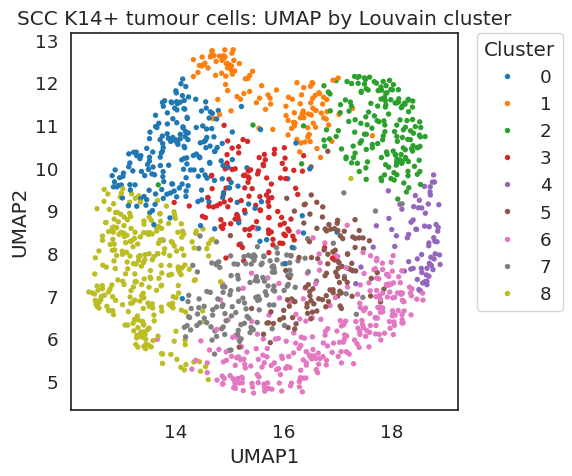

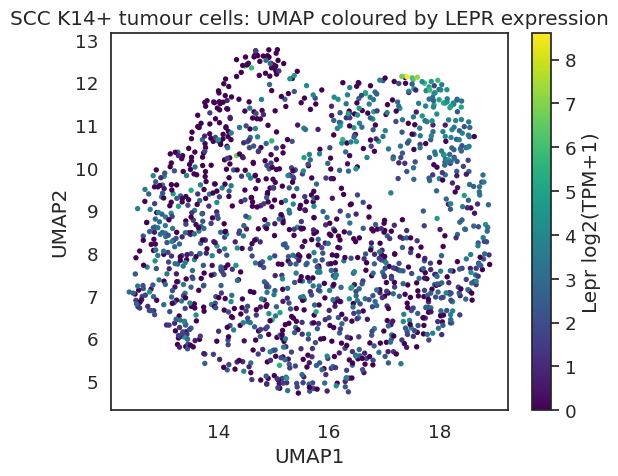

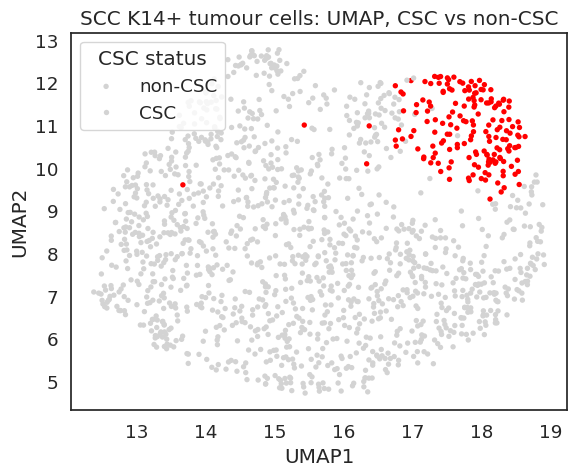

In [23]:
# %%
# Set default style for plots
sns.set(style="white", font_scale=1.2)

# Create output directory for figures
fig_dir = project_root / "figures" / "main"
fig_dir.mkdir(parents=True, exist_ok=True)

# UMAP coloured by Louvain cluster
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=metadata_k14,
    x="UMAP1",
    y="UMAP2",
    hue="louvain_cluster",
    palette="tab10",
    s=15,
    linewidth=0,
)
plt.title("SCC K14+ tumour cells: UMAP by Louvain cluster")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(
    title="Cluster",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
)
plt.tight_layout()
plt.savefig(fig_dir / "scc_scRNA_umap_louvain_clusters.png", dpi=300)
plt.show()

# UMAP coloured by LEPR expression
plt.figure(figsize=(6, 5))
sc = plt.scatter(
    metadata_k14["UMAP1"],
    metadata_k14["UMAP2"],
    c=metadata_k14["Lepr_expr"],
    s=15,
    cmap="viridis",
    linewidths=0,
)
plt.colorbar(sc, label="Lepr log2(TPM+1)")
plt.title("SCC K14+ tumour cells: UMAP coloured by LEPR expression")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.savefig(fig_dir / "scc_scRNA_umap_Lepr_expr.png", dpi=300)
plt.show()

# UMAP with CSC vs non-CSC
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=metadata_k14,
    x="UMAP1",
    y="UMAP2",
    hue="is_CSC",
    palette={False: "lightgray", True: "red"},
    s=15,
    linewidth=0,
)
plt.title("SCC K14+ tumour cells: UMAP, CSC vs non-CSC")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="CSC status", labels=["non-CSC", "CSC"])
plt.tight_layout()
plt.savefig(fig_dir / "scc_scRNA_umap_CSC_vs_nonCSC.png", dpi=300)
plt.show()

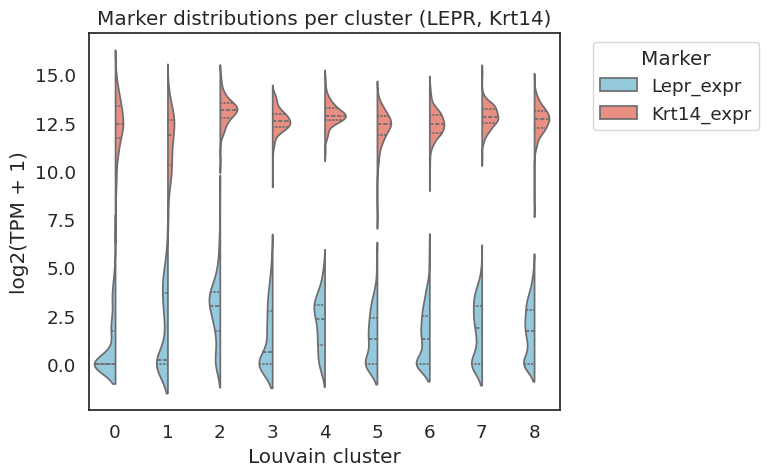

In [24]:
# %%
# Melt metadata for violin plots
marker_long = metadata_k14.melt(
    id_vars=["louvain_cluster"],
    value_vars=["Lepr_expr", "Krt14_expr"],
    var_name="marker",
    value_name="log2_TPM_plus1",
)

# Violin plots per cluster per marker
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=marker_long,
    x="louvain_cluster",
    y="log2_TPM_plus1",
    hue="marker",
    split=True,
    inner="quartile",
    palette={"Lepr_expr": "skyblue", "Krt14_expr": "salmon"},
)
plt.xlabel("Louvain cluster")
plt.ylabel("log2(TPM + 1)")
plt.title("Marker distributions per cluster (LEPR, Krt14)")
plt.legend(title="Marker", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(fig_dir / "scc_scRNA_violin_markers_by_cluster.png", dpi=300)
plt.show()

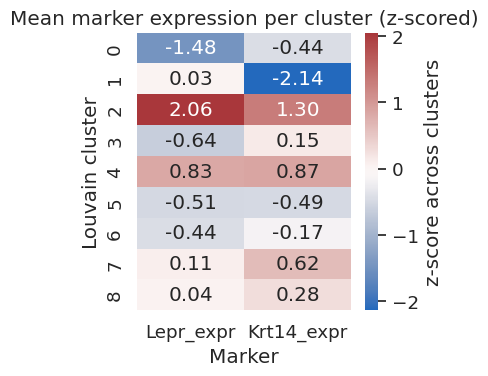

In [25]:
# %%
# Build per-cluster summary for heatmap
cluster_marker_means = metadata_k14.groupby("louvain_cluster")[
    ["Lepr_expr", "Krt14_expr"]
].mean()

# Z-score across clusters to emphasise relative differences
cluster_marker_z = (
    cluster_marker_means - cluster_marker_means.mean(axis=0)
) / cluster_marker_means.std(axis=0)

plt.figure(figsize=(4, 4))
sns.heatmap(
    cluster_marker_z,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    cbar_kws={"label": "z-score across clusters"},
)
plt.title("Mean marker expression per cluster (z-scored)")
plt.ylabel("Louvain cluster")
plt.xlabel("Marker")
plt.tight_layout()
plt.savefig(fig_dir / "scc_scRNA_cluster_marker_heatmap.png", dpi=300)
plt.show()

/tmp/ipykernel_104105/1415829593.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


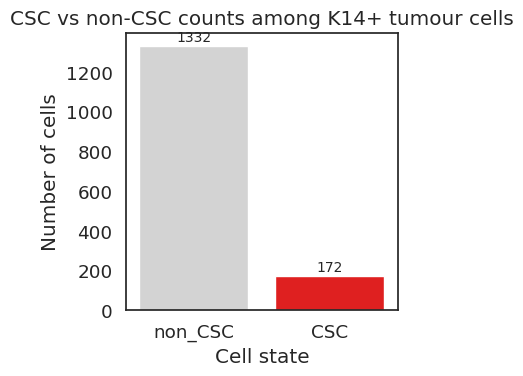

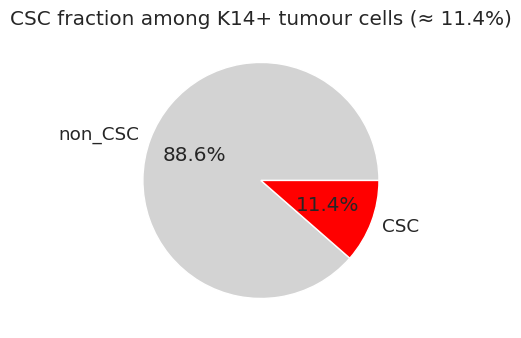

In [26]:
# %%
# Bar plot of CSC vs non-CSC counts
csc_counts = metadata_k14["is_CSC"].value_counts().rename(
    index={False: "non_CSC", True: "CSC"}
)

plt.figure(figsize=(4, 4))
sns.barplot(
    x=csc_counts.index,
    y=csc_counts.values,
    palette=["lightgray", "red"],
)
plt.ylabel("Number of cells")
plt.xlabel("Cell state")
plt.title("CSC vs non-CSC counts among K14+ tumour cells")
for i, v in enumerate(csc_counts.values):
    plt.text(i, v + 10, str(v), ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.savefig(fig_dir / "scc_scRNA_CSC_vs_nonCSC_counts.png", dpi=300)
plt.show()

# Pie chart of CSC fraction
csc_fraction = float(metadata_k14["is_CSC"].mean())

plt.figure(figsize=(4, 4))
plt.pie(
    csc_counts.values,
    labels=csc_counts.index,
    autopct="%1.1f%%",
    colors=["lightgray", "red"],
)
plt.title(f"CSC fraction among K14+ tumour cells (≈ {csc_fraction:.1%})")
plt.tight_layout()
plt.savefig(fig_dir / "scc_scRNA_CSC_fraction_pie.png", dpi=300)
plt.show()

In [27]:
# %%
# Example Ensembl-based modules (placeholder, you should refine)
tgfb_module_genes = [
    # Fill with Ensembl IDs from your bulk / scRNA module table
    # e.g. "ENSMUSG00000028184.13",  # Smad2
]

pi3k_mtor_module_genes = [
    # e.g. "ENSMUSG00000024403.5",   # Akt1
]

angiogenesis_module_genes = [
    # e.g. "ENSMUSG00000043957.12",  # Vegfa
]

# Compute module scores where gene lists are non-empty
module_scores = {}

if len(tgfb_module_genes) > 0:
    module_scores["TGFb_score"] = compute_module_score(
        log_tpm_k14=log_tpm_k14,
        gene_list=tgfb_module_genes,
        module_name="TGFb"
    )

if len(pi3k_mtor_module_genes) > 0:
    module_scores["PI3K_mTOR_score"] = compute_module_score(
        log_tpm_k14=log_tpm_k14,
        gene_list=pi3k_mtor_module_genes,
        module_name="PI3K_mTOR"
    )

if len(angiogenesis_module_genes) > 0:
    module_scores["Angiogenesis_score"] = compute_module_score(
        log_tpm_k14=log_tpm_k14,
        gene_list=angiogenesis_module_genes,
        module_name="Angiogenesis"
    )

# Attach to metadata if any modules were computed
for name, series in module_scores.items():
    metadata_k14[name] = series

# Quick plot: module scores by CSC status
if module_scores:
    ms_long = metadata_k14.melt(
        id_vars=["is_CSC"],
        value_vars=list(module_scores.keys()),
        var_name="module",
        value_name="score",
    )

    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=ms_long,
        x="module",
        y="score",
        hue="is_CSC",
        palette={False: "lightgray", True: "red"},
    )
    plt.title("Module scores in CSC vs non-CSC")
    plt.xlabel("Module")
    plt.ylabel("Average z-score")
    plt.legend(title="CSC", labels=["non-CSC", "CSC"])
    plt.tight_layout()
    plt.savefig(fig_dir / "scc_scRNA_module_scores_CSC_vs_nonCSC.png", dpi=300)
    plt.show()
else:
    print("No module scores defined yet. Fill in module gene lists first.")

No module scores defined yet. Fill in module gene lists first.
